# Importing Libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from math import sqrt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import seaborn as sns
from pandas.plotting import lag_plot
from pandas import datetime
import time
import os
import pandas as pd
import math
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import GRU, LSTM, Bidirectional, Dense, Flatten, Conv1D, BatchNormalization, LeakyReLU, Dropout, SimpleRNN, GRU, Bidirectional
from pickle import load
from pandas.plotting import lag_plot

# Importing Dataset

In [2]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
data = pd.read_csv('^NSEI.csv', sep=',', parse_dates=['Date'], index_col='Date',date_parser=dateparse)
plt.figure(figsize=(16,8))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Open Prices')
plt.plot(data['Open']);

FileNotFoundError: ignored

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


          t-1       t+1
t-1  1.000000  0.017292
t+1  0.017292  1.000000


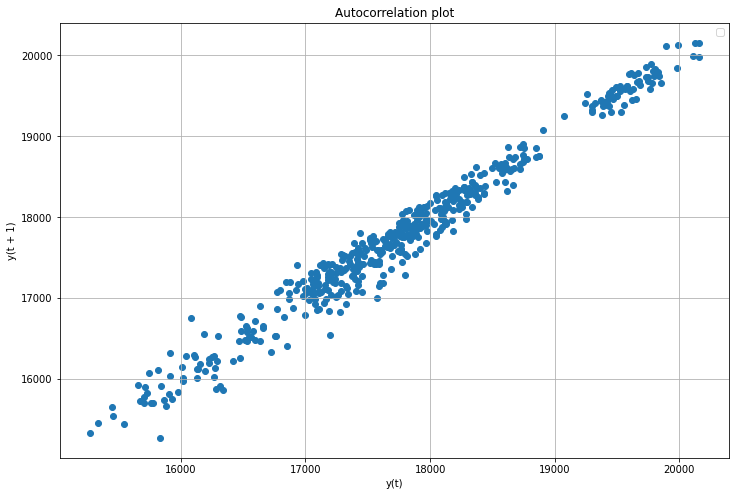

In [ ]:
from pandas.plotting import lag_plot
plt.figure(figsize=(12,8))
lag_plot(data['Open'], lag=1)
plt.title('Autocorrelation plot')
plt.grid(True)
plt.legend();

from pandas import DataFrame
from pandas import concat
values = DataFrame(data['Open'].values)
dataframe = concat([values.shift(120), values], axis=1)
dataframe.columns = ['t-1', 't+1']
result = dataframe.corr()
print(result)

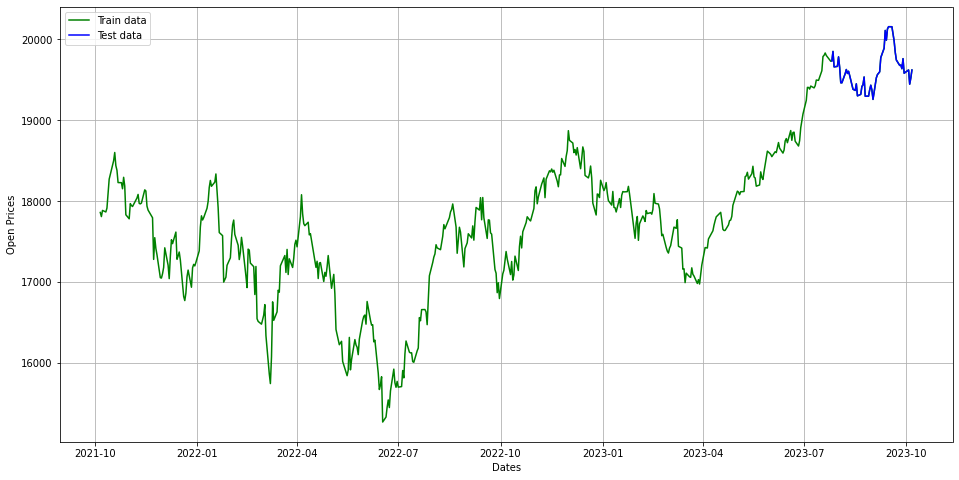

In [ ]:
train_data, test_data = data[0:int(len(data)*0.9)], data[int(len(data)*0.9):]
plt.figure(figsize=(16,8))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Open Prices')
plt.plot(data['Open'], 'green', label='Train data')
plt.plot(test_data['Open'], 'blue', label='Test data')
plt.legend()

# LSTM

In [ ]:
train = train_data.iloc[:, 0:1].values

In [ ]:
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train)

In [ ]:
timesteps = 7
X_train = []
y_train = []
for i in range(timesteps, train.shape[0]):
    X_train.append(train_scaled[i-timesteps:i, 0])
    y_train.append(train_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [ ]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1)) #Reshaping
from numpy.random import seed
seed(2019)

In [ ]:
model = Sequential()
model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))

model.add(Dropout(0.20))

model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.25))

model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 50))
model.add(Dropout(0.25))


model.add(Dense(units = 1))

In [ ]:
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 7, 50)             10400     
_________________________________________________________________
dropout (Dropout)            (None, 7, 50)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 7, 50)             20200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 50)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 7, 50)             20200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 7, 50)             0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                2

In [ ]:
model.fit(X_train, y_train, epochs = 40, batch_size = 32)

Epoch 1/40
14/14 [==============================] - 3s 4ms/step - loss: 0.1497
Epoch 2/40
14/14 [==============================] - 0s 4ms/step - loss: 0.0330
Epoch 3/40
14/14 [==============================] - 0s 3ms/step - loss: 0.0231
Epoch 4/40
14/14 [==============================] - 0s 4ms/step - loss: 0.0162
Epoch 5/40
14/14 [==============================] - 0s 4ms/step - loss: 0.0128
Epoch 6/40
14/14 [==============================] - 0s 4ms/step - loss: 0.0104
Epoch 7/40
14/14 [==============================] - 0s 4ms/step - loss: 0.0114
Epoch 8/40
14/14 [==============================] - 0s 3ms/step - loss: 0.0112
Epoch 9/40
14/14 [==============================] - 0s 4ms/step - loss: 0.0097
Epoch 10/40
14/14 [==============================] - 0s 4ms/step - loss: 0.0098
Epoch 11/40
14/14 [==============================] - 0s 4ms/step - loss: 0.0098
Epoch 12/40
14/14 [==============================] - 0s 4ms/step - loss: 0.0097
Epoch 13/40
14/14 [==============================

In [ ]:
real_stock_price = test_data.iloc[:,0:1].values

In [ ]:
combine = pd.concat((train_data['Open'], test_data['Open']), axis = 0)

test_inputs = combine[len(combine) - len(test_data) - timesteps:].values
test_inputs = test_inputs.reshape(-1,1)
test_inputs = scaler.transform(test_inputs)

In [ ]:
X_test = []
for i in range(timesteps, test_data.shape[0]+timesteps):
    X_test.append(test_inputs[i-timesteps:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_stock_price = model.predict(X_test)

predicted_stock_price = scaler.inverse_transform(predicted_stock_price)

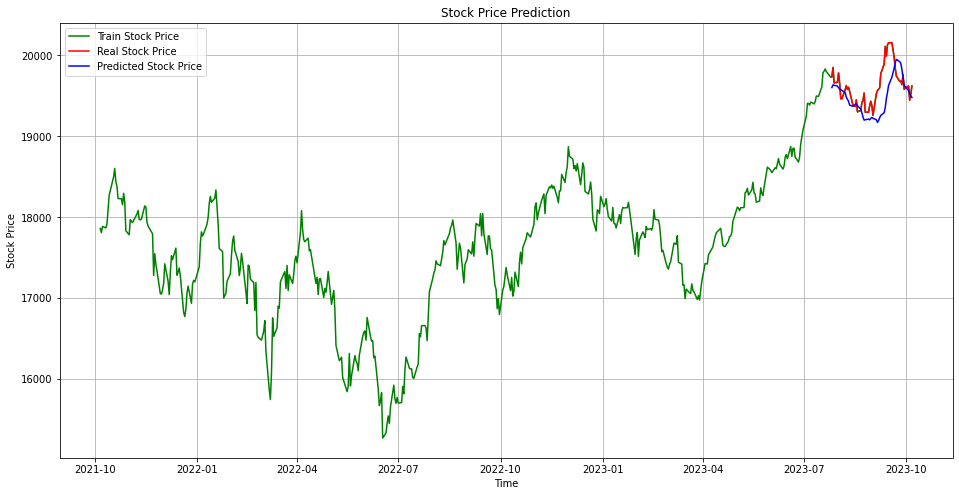

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(data.index[-600:], data['Open'].tail(600), color='green', label = 'Train Stock Price')
plt.plot(test_data.index, real_stock_price, color = 'red', label = 'Real Stock Price')
plt.plot(test_data.index, predicted_stock_price, color = 'blue', label = 'Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
mse = mean_squared_error(real_stock_price, predicted_stock_price)
print('MSE: '+str(mse))
mae = mean_absolute_error(real_stock_price, predicted_stock_price)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(real_stock_price, predicted_stock_price))
print('RMSE: '+str(rmse))
r2 = r2_score(real_stock_price, predicted_stock_price)
print('R2 Score: ' + str(r2))

MSE: 71623.25264381409
MAE: 199.4903515625
RMSE: 267.6252092830832
R2 Score: -0.3504377363344935


# RNN

In [ ]:
model = Sequential()
model.add(SimpleRNN(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))  # Use SimpleRNN

model.add(Dropout(0.20))

model.add(SimpleRNN(units=50, return_sequences=True))  # Use SimpleRNN
model.add(Dropout(0.25))

model.add(SimpleRNN(units=50, return_sequences=True))  # Use SimpleRNN
model.add(Dropout(0.2))

model.add(SimpleRNN(units=50))  # Use SimpleRNN
model.add(Dropout(0.25))

model.add(Dense(units=1))

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 7, 50)             2600      
_________________________________________________________________
dropout_4 (Dropout)          (None, 7, 50)             0         
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 7, 50)             5050      
_________________________________________________________________
dropout_5 (Dropout)          (None, 7, 50)             0         
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 7, 50)             5050      
_________________________________________________________________
dropout_6 (Dropout)          (None, 7, 50)             0         
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, 50)               

In [ ]:
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
model.fit(X_train, y_train, epochs = 40, batch_size = 32)

Epoch 1/40
14/14 [==============================] - 1s 12ms/step - loss: 0.6099
Epoch 2/40
14/14 [==============================] - 0s 11ms/step - loss: 0.4287
Epoch 3/40
14/14 [==============================] - 0s 10ms/step - loss: 0.3708
Epoch 4/40
14/14 [==============================] - 0s 10ms/step - loss: 0.3102
Epoch 5/40
14/14 [==============================] - 0s 10ms/step - loss: 0.2500
Epoch 6/40
14/14 [==============================] - 0s 9ms/step - loss: 0.1860
Epoch 7/40
14/14 [==============================] - 0s 9ms/step - loss: 0.1554
Epoch 8/40
14/14 [==============================] - 0s 9ms/step - loss: 0.1325
Epoch 9/40
14/14 [==============================] - 0s 9ms/step - loss: 0.1223
Epoch 10/40
14/14 [==============================] - 0s 9ms/step - loss: 0.1119
Epoch 11/40
14/14 [==============================] - 0s 9ms/step - loss: 0.1020
Epoch 12/40
14/14 [==============================] - 0s 9ms/step - loss: 0.0884
Epoch 13/40
14/14 [=========================

In [ ]:
real_stock_price = test_data.iloc[:,0:1].values

In [ ]:
combine = pd.concat((train_data['Open'], test_data['Open']), axis = 0)

test_inputs = combine[len(combine) - len(test_data) - timesteps:].values
test_inputs = test_inputs.reshape(-1,1)
test_inputs = scaler.transform(test_inputs)

In [ ]:
X_test = []
for i in range(timesteps, test_data.shape[0]+timesteps):
    X_test.append(test_inputs[i-timesteps:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_stock_price = model.predict(X_test)

predicted_stock_price = scaler.inverse_transform(predicted_stock_price)

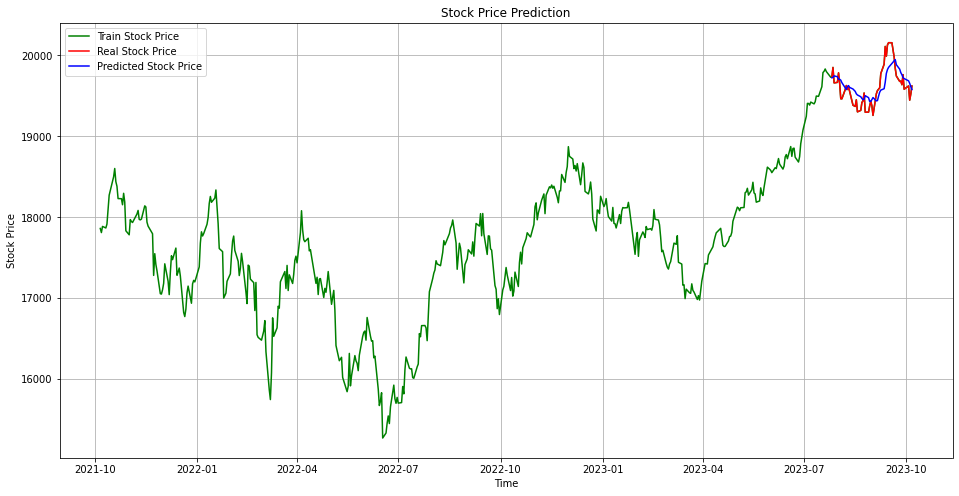

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(data.index[-600:], data['Open'].tail(600), color='green', label = 'Train Stock Price')
plt.plot(test_data.index, real_stock_price, color = 'red', label = 'Real Stock Price')
plt.plot(test_data.index, predicted_stock_price, color = 'blue', label = 'Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
mse1 = mean_squared_error(real_stock_price, predicted_stock_price)
print('MSE: '+str(mse1))
mae1 = mean_absolute_error(real_stock_price, predicted_stock_price)
print('MAE: '+str(mae1))
rmse1 = math.sqrt(mean_squared_error(real_stock_price, predicted_stock_price))
print('RMSE: '+str(rmse1))
r21 = r2_score(real_stock_price, predicted_stock_price)
print('R2 Score: ' + str(r21))

MSE: 24901.642696533203
MAE: 127.46796875
RMSE: 157.80254337789745
R2 Score: 0.5304860257973631


# GRU

In [ ]:
model = Sequential()
model.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))

model.add(Dropout(0.20))

model.add(GRU(units=50, return_sequences=True))
model.add(Dropout(0.25))

model.add(GRU(units=50, return_sequences=True))
model.add(Dropout(0.2))

model.add(GRU(units=50))
model.add(Dropout(0.25))

model.add(Dense(units=1))

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 7, 50)             7950      
_________________________________________________________________
dropout_8 (Dropout)          (None, 7, 50)             0         
_________________________________________________________________
gru_1 (GRU)                  (None, 7, 50)             15300     
_________________________________________________________________
dropout_9 (Dropout)          (None, 7, 50)             0         
_________________________________________________________________
gru_2 (GRU)                  (None, 7, 50)             15300     
_________________________________________________________________
dropout_10 (Dropout)         (None, 7, 50)             0         
_________________________________________________________________
gru_3 (GRU)                  (None, 50)               

In [ ]:
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
model.fit(X_train, y_train, epochs = 40, batch_size = 32)

Epoch 1/40
14/14 [==============================] - 2s 5ms/step - loss: 0.0737
Epoch 2/40
14/14 [==============================] - 0s 5ms/step - loss: 0.0203
Epoch 3/40
14/14 [==============================] - 0s 6ms/step - loss: 0.0148
Epoch 4/40
14/14 [==============================] - 0s 4ms/step - loss: 0.0117
Epoch 5/40
14/14 [==============================] - 0s 4ms/step - loss: 0.0099
Epoch 6/40
14/14 [==============================] - 0s 4ms/step - loss: 0.0086
Epoch 7/40
14/14 [==============================] - 0s 4ms/step - loss: 0.0093
Epoch 8/40
14/14 [==============================] - 0s 3ms/step - loss: 0.0088
Epoch 9/40
14/14 [==============================] - 0s 3ms/step - loss: 0.0089
Epoch 10/40
14/14 [==============================] - 0s 3ms/step - loss: 0.0079
Epoch 11/40
14/14 [==============================] - 0s 3ms/step - loss: 0.0088
Epoch 12/40
14/14 [==============================] - 0s 3ms/step - loss: 0.0072
Epoch 13/40
14/14 [==============================

In [ ]:
real_stock_price = test_data.iloc[:,0:1].values
combine = pd.concat((train_data['Open'], test_data['Open']), axis = 0)

test_inputs = combine[len(combine) - len(test_data) - timesteps:].values
test_inputs = test_inputs.reshape(-1,1)
test_inputs = scaler.transform(test_inputs)

X_test = []
for i in range(timesteps, test_data.shape[0]+timesteps):
    X_test.append(test_inputs[i-timesteps:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_stock_price = model.predict(X_test)

predicted_stock_price = scaler.inverse_transform(predicted_stock_price)

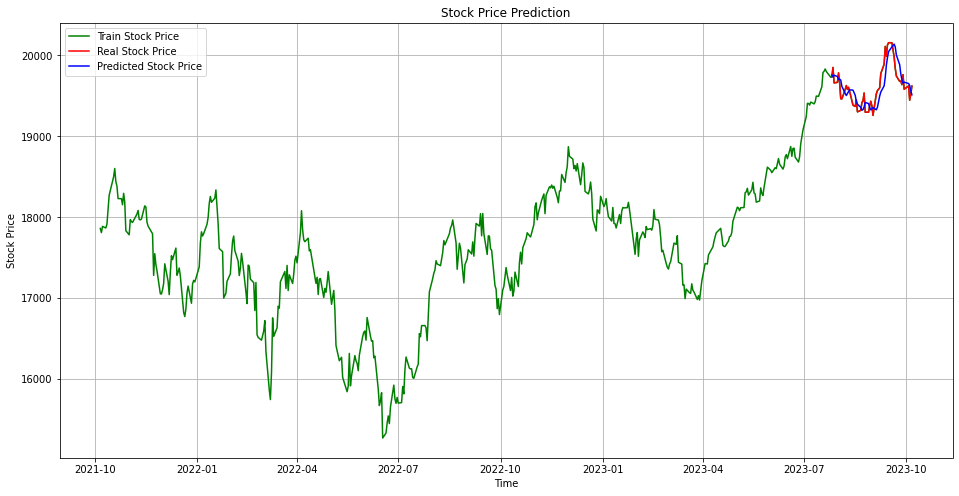

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(data.index[-600:], data['Open'].tail(600), color='green', label = 'Train Stock Price')
plt.plot(test_data.index, real_stock_price, color = 'red', label = 'Real Stock Price')
plt.plot(test_data.index, predicted_stock_price, color = 'blue', label = 'Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
mse2 = mean_squared_error(real_stock_price, predicted_stock_price)
print('MSE: '+str(mse2))
mae2 = mean_absolute_error(real_stock_price, predicted_stock_price)
print('MAE: '+str(mae2))
rmse2 = math.sqrt(mean_squared_error(real_stock_price, predicted_stock_price))
print('RMSE: '+str(rmse2))
r22 = r2_score(real_stock_price, predicted_stock_price)
print('R2 Score: ' + str(r22))

MSE: 20393.135921859743
MAE: 120.3305859375
RMSE: 142.80453746943667
R2 Score: 0.6154927444019614


# BiLSTM

In [ ]:
model = Sequential()
model.add(Bidirectional(LSTM(units=50, return_sequences=True), input_shape=(X_train.shape[1], 1)))

model.add(Dropout(0.20))

model.add(Bidirectional(LSTM(units=50, return_sequences=True)))
model.add(Dropout(0.25))

model.add(Bidirectional(LSTM(units=50, return_sequences=True)))
model.add(Dropout(0.2))

model.add(Bidirectional(LSTM(units=50)))
model.add(Dropout(0.25))

model.add(Dense(units=1))

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 7, 100)            20800     
_________________________________________________________________
dropout_12 (Dropout)         (None, 7, 100)            0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 7, 100)            60400     
_________________________________________________________________
dropout_13 (Dropout)         (None, 7, 100)            0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 7, 100)            60400     
_________________________________________________________________
dropout_14 (Dropout)         (None, 7, 100)            0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 100)              

In [ ]:
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
model.fit(X_train, y_train, epochs = 40, batch_size = 32)

Epoch 1/40
14/14 [==============================] - 4s 11ms/step - loss: 0.0845
Epoch 2/40
14/14 [==============================] - 0s 10ms/step - loss: 0.0198
Epoch 3/40
14/14 [==============================] - 0s 6ms/step - loss: 0.0131
Epoch 4/40
14/14 [==============================] - 0s 6ms/step - loss: 0.0078
Epoch 5/40
14/14 [==============================] - 0s 6ms/step - loss: 0.0064
Epoch 6/40
14/14 [==============================] - 0s 6ms/step - loss: 0.0062
Epoch 7/40
14/14 [==============================] - 0s 6ms/step - loss: 0.0059
Epoch 8/40
14/14 [==============================] - 0s 6ms/step - loss: 0.0065
Epoch 9/40
14/14 [==============================] - 0s 6ms/step - loss: 0.0071
Epoch 10/40
14/14 [==============================] - 0s 6ms/step - loss: 0.0068
Epoch 11/40
14/14 [==============================] - 0s 6ms/step - loss: 0.0053
Epoch 12/40
14/14 [==============================] - 0s 6ms/step - loss: 0.0055
Epoch 13/40
14/14 [============================

In [ ]:
real_stock_price = test_data.iloc[:,0:1].values
combine = pd.concat((train_data['Open'], test_data['Open']), axis = 0)

test_inputs = combine[len(combine) - len(test_data) - timesteps:].values
test_inputs = test_inputs.reshape(-1,1)
test_inputs = scaler.transform(test_inputs)

X_test = []
for i in range(timesteps, test_data.shape[0]+timesteps):
    X_test.append(test_inputs[i-timesteps:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_stock_price = model.predict(X_test)

predicted_stock_price = scaler.inverse_transform(predicted_stock_price)

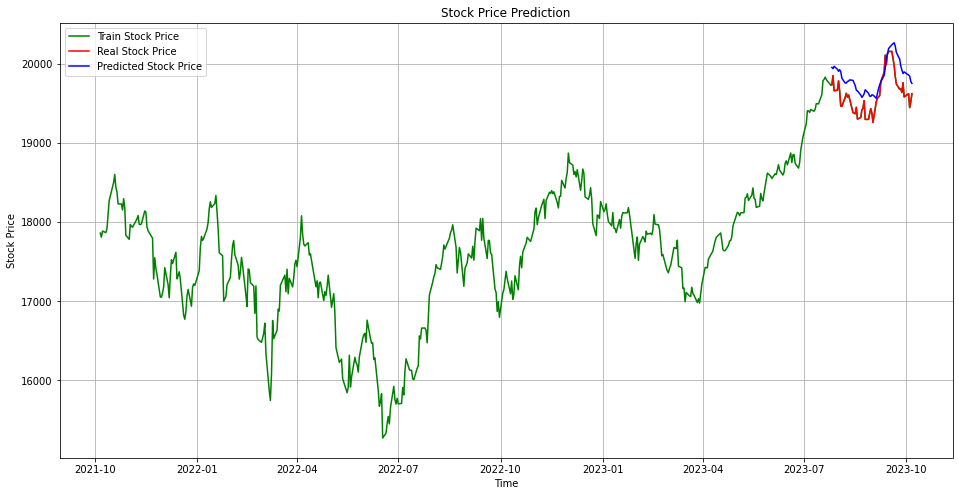

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(data.index[-600:], data['Open'].tail(600), color='green', label = 'Train Stock Price')
plt.plot(test_data.index, real_stock_price, color = 'red', label = 'Real Stock Price')
plt.plot(test_data.index, predicted_stock_price, color = 'blue', label = 'Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
mse3 = mean_squared_error(real_stock_price, predicted_stock_price)
print('MSE: '+str(mse3))
mae3 = mean_absolute_error(real_stock_price, predicted_stock_price)
print('MAE: '+str(mae3))
rmse3 = math.sqrt(mean_squared_error(real_stock_price, predicted_stock_price))
print('RMSE: '+str(rmse3))
r23 = r2_score(real_stock_price, predicted_stock_price)
print('R2 Score: ' + str(r23))

MSE: 61659.84852798462
MAE: 217.824765625
RMSE: 248.31401194452283
R2 Score: -0.1625803519836504


# Comparison

In [ ]:


results = {
    'R-squared': [r2, r21,r22,r23],
    'Mean Squared Error': [mse, mse1,mse2,mse3],
    'Mean Absolute Error': [mae, mae1,mae2,mae3],
    'Root Mean Squared Error': [rmse,rmse1,rmse2,rmse3]
}

index = ['LSTM','RNN', 'GRU','BiLSTM']

In [ ]:
results =pd.DataFrame(results,index=index)

In [ ]:
print(results)

        R-squared  Mean Squared Error  Mean Absolute Error  \
LSTM    -0.350438        71623.252644           199.490352   
RNN      0.530486        24901.642697           127.467969   
GRU      0.615493        20393.135922           120.330586   
BiLSTM  -0.162580        61659.848528           217.824766   

        Root Mean Squared Error  
LSTM                 267.625209  
RNN                  157.802543  
GRU                  142.804537  
BiLSTM               248.314012  


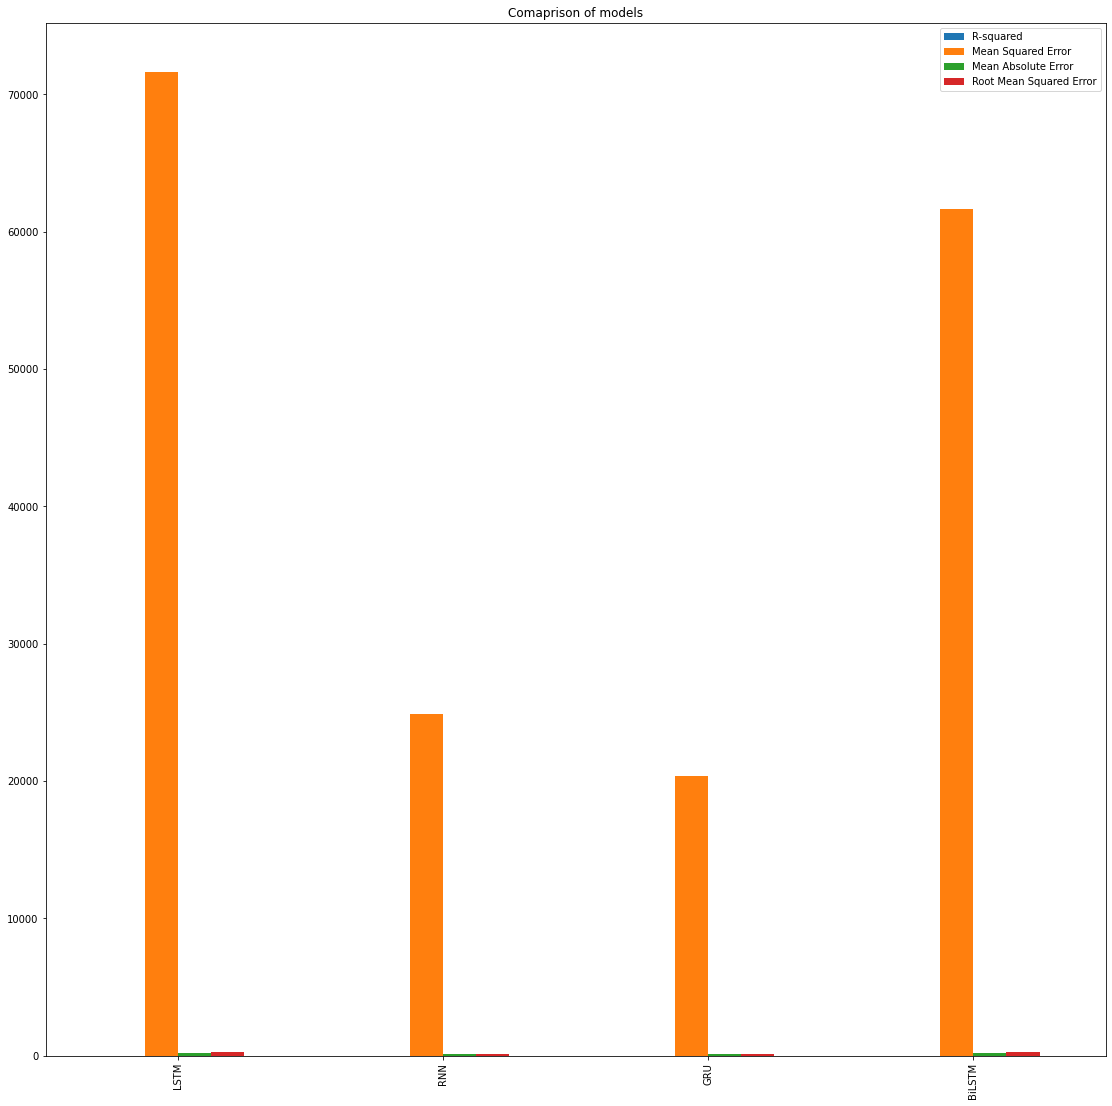

In [ ]:
fig =results.plot(kind='bar',title='Comaprison of models',figsize =(19,19)).get_figure()
fig.savefig('Final Result.png')

array([<AxesSubplot:title={'center':'R-squared'}>,
       <AxesSubplot:title={'center':'Mean Squared Error'}>,
       <AxesSubplot:title={'center':'Mean Absolute Error'}>,
       <AxesSubplot:title={'center':'Root Mean Squared Error'}>],
      dtype=object)

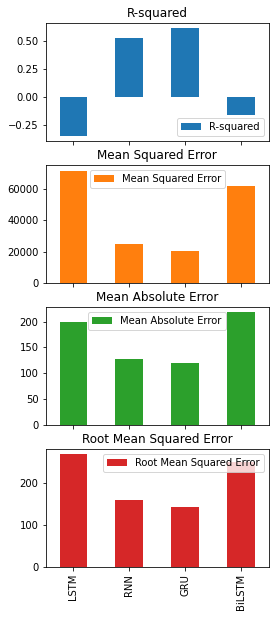

In [ ]:
results.plot(subplots=True,kind ='bar',figsize=(4,10))